In [1]:
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [2]:
target_sample_rate = 44100
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            target_sample_rate = sr
            path = file.split(os.path.sep)
            filename = f'{path[-1]}'
            wav_files.append((y, filename))
    return wav_files

In [3]:
segmented_files_anomaly = load_segmented_files('output_anomaly')
# 打亂 segmented_files_anomaly 列表
np.random.shuffle(segmented_files_anomaly)

100%|██████████| 5025/5025 [00:03<00:00, 1300.27it/s]


In [4]:
print(segmented_files_anomaly[0])

(array([-0.00119019, -0.06677246, -0.11932373, ...,  0.08190918,
       -0.20272827, -0.14642334], dtype=float32), '34A-8-25-2-anomaly_Mic010_segment_0.wav')


In [5]:
def normalize_audio(wav):
    # 標準化音頻信號
    factor = np.max(np.abs(wav))
    if factor == 0:
        return wav
    return wav / factor

def hamming_window(wav):
    # 應用漢明窗以減少邊緣效應
    return wav * np.hamming(len(wav))

def convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels):
    audio = normalize_audio(audio)
    audio = hamming_window(audio)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=target_sample_rate, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [14]:
# 指定 STFT 參數
hop_length = 64
n_mels = 128
n_fft = 256

In [15]:
def plot_comparison(input_mel_spectrogram, output_mel_spectrogram, input_title, output_title, output_name='comparison', save_only=False):
    plt.figure(figsize=(20, 5))
    
    # 繪製輸入梅爾頻譜圖
    plt.subplot(1, 2, 1)
    librosa.display.specshow(input_mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(input_title)
    
    # 繪製輸出梅爾頻譜圖
    plt.subplot(1, 2, 2)
    librosa.display.specshow(output_mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(output_title)
    
    plt.tight_layout()
    if save_only:
        plt.savefig(f'{output_name}.png')
        plt.close()
    else:
        plt.show()

In [16]:
mel_spectrograms_anomaly_array = [convert_to_mel_spectrogram(audio[0], n_fft, hop_length, n_mels) for audio in
                           tqdm(segmented_files_anomaly[:500])]
# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_anomaly_array = np.array(mel_spectrograms_anomaly_array)
# 調整數據的形狀
mel_spectrograms_anomaly_array = mel_spectrograms_anomaly_array.reshape(mel_spectrograms_anomaly_array.shape[0],
                                                                        mel_spectrograms_anomaly_array.shape[1],
                                                                        mel_spectrograms_anomaly_array.shape[2], 1)

# 數據歸一化到 [0, 1]
mel_spectrograms_anomaly_array = (mel_spectrograms_anomaly_array - mel_spectrograms_anomaly_array.min()) / (
            mel_spectrograms_anomaly_array.max() - mel_spectrograms_anomaly_array.min())

print(mel_spectrograms_anomaly_array.shape)

100%|██████████| 500/500 [00:03<00:00, 146.78it/s]


(500, 128, 1379, 1)


# Load the trained autoencoder model

In [17]:
from tensorflow.keras.models import load_model
autoencoder = load_model('mel_autoencoder.h5')

In [18]:
# 檢查模型結構
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1379, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 1379, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 690, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 690, 8)        1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 345, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 345, 8)        584   

In [19]:
# 驗證異常數據
mel_spectrograms_anomaly_array_reconstructed = autoencoder.predict(mel_spectrograms_anomaly_array)
print(mel_spectrograms_anomaly_array.shape, mel_spectrograms_anomaly_array_reconstructed.shape)

16/16 [==============================] - 4s 27ms/step
(500, 128, 1379, 1) (500, 128, 1379, 1)


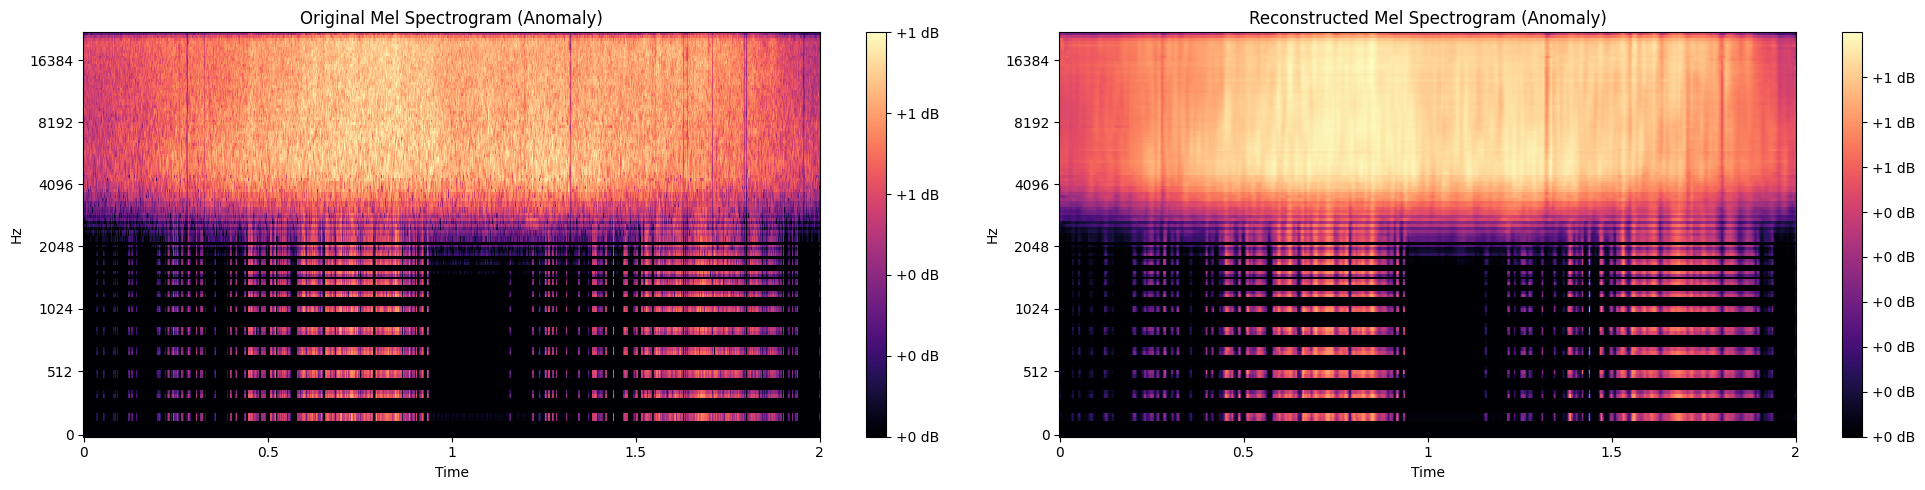

In [20]:
anomaly_index = 15
plot_comparison(
    mel_spectrograms_anomaly_array[anomaly_index].reshape(mel_spectrograms_anomaly_array[anomaly_index].shape[0],
                                                          mel_spectrograms_anomaly_array[anomaly_index].shape[1]),
    mel_spectrograms_anomaly_array_reconstructed[anomaly_index].reshape(
        mel_spectrograms_anomaly_array_reconstructed[anomaly_index].shape[0],
        mel_spectrograms_anomaly_array_reconstructed[anomaly_index].shape[1]),
    'Original Mel Spectrogram (Anomaly)', 'Reconstructed Mel Spectrogram (Anomaly)')

In [22]:
for i in tqdm(range(0, len(mel_spectrograms_anomaly_array))):
    plot_comparison(
        mel_spectrograms_anomaly_array[i].reshape(mel_spectrograms_anomaly_array[i].shape[0],
                                                  mel_spectrograms_anomaly_array[i].shape[1]),
        mel_spectrograms_anomaly_array_reconstructed[i].reshape(
            mel_spectrograms_anomaly_array_reconstructed[i].shape[0],
            mel_spectrograms_anomaly_array_reconstructed[i].shape[1]),
        'Original Mel Spectrogram (Anomaly)', 'Reconstructed Mel Spectrogram (Anomaly)' , output_name=f'images/reconstruct_anomaly/{segmented_files_anomaly[i][1]}', save_only=True)

100%|██████████| 500/500 [03:44<00:00,  2.23it/s]


In [23]:
mse = np.mean((mel_spectrograms_anomaly_array - mel_spectrograms_anomaly_array_reconstructed) ** 2)
print("Reconstruction MSE (Anomaly):", mse)

Reconstruction MSE (Anomaly): 0.0022222064284960134
